Sequential
--

In [1]:
import sys
sys.path.append("../")

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import callbacks, backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, concatenate
from tensorflow.keras.constraints import max_norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse as sp

from utils import clean_text
from utils.metrics import Report

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Import Data

In [3]:
data_path = '../../data/'

In [4]:
with open(data_path + 'categories_string.csv') as f:
    categories = dict(map(lambda x:x.strip('\n').split(',')[::-1], f.readlines()[1:]))

X = pd.read_json(data_path + 'train.json').set_index('Id')
y = pd.read_csv(data_path + 'train_label.csv', index_col='Id', dtype={'Category': 'category'}).Category

# Preparing data
Words number per X

<AxesSubplot:>

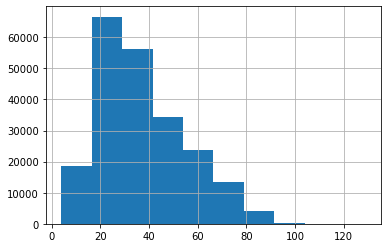

In [5]:
X['gender_name'] = X.gender
X.gender = X.loc[:, 'gender'].astype('category').cat.codes.rename("gender_cat")
X.description = X.description.apply(clean_text)

X.description.apply(lambda x:x.split().__len__()).hist()

Split to train and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 1/3, random_state=42069)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

### Global features and hyper params dimension

In [7]:
vocab_size = 6000
input_length = vocab_size + 1
num_labels = 28
batch_size = 512
nb_epoch = 40

## Processing X
Converting description to word sequence.  
Adding `gender` categorical feature to `x`.

In [8]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train.description)

In [9]:
desc_train = tokenizer.texts_to_matrix(X_train.description, mode='tfidf')
desc_test = tokenizer.texts_to_matrix(X_test.description, mode='tfidf')

In [10]:
x_train = sp.hstack((sp.csr_matrix(desc_train), X_train.gender.to_numpy('float64').reshape(-1,1)-2)).tocsr()
x_test = sp.hstack((sp.csr_matrix(desc_test), X_test.gender.to_numpy('float64').reshape(-1,1)-2)).tocsr()

## Processing Y
Convert Y to matrix

In [11]:
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Model
Sequential

## Training

In [12]:
model = Sequential()

model.add(Dense(4096, input_shape=(input_length,), activation = 'relu', kernel_initializer = 'glorot_normal', kernel_constraint=max_norm(2)))
model.add(Dropout(0.1))

model.add(Dense(1024, kernel_initializer = 'glorot_normal', activation= 'relu'))
model.add(Dropout(0.1))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              24584192  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 28)                28700     
_________________________________________________________________
activation (Activation)      (None, 28)                0         
Total params: 28,808,220
Trainable params: 28,808,220
Non-trainable params: 0
____________________________________________

Compile and fit model.  
Accuracy is observed on validation set *(20%)*.
F1 score will be observed on the test set.

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['acc']
)

with tf.device('/gpu:0'):
    history = model.fit(
        sp.lil_matrix(x_train.astype('float16')).A, y_train,
        batch_size=batch_size,
        epochs=nb_epoch,
        verbose=1,
        validation_split = .1,
        use_multiprocessing = True
    )

Train on 130318 samples, validate on 14480 samples
Epoch 1/40
130318/130318 [==============================] - 15s 115us/sample - loss: 2.1914 - acc: 0.4276 - val_loss: 1.7536 - val_acc: 0.5506
Epoch 2/40
130318/130318 [==============================] - 14s 111us/sample - loss: 1.5206 - acc: 0.6134 - val_loss: 1.3327 - val_acc: 0.6646
Epoch 3/40
130318/130318 [==============================] - 15s 111us/sample - loss: 1.2125 - acc: 0.6904 - val_loss: 1.1203 - val_acc: 0.7135
Epoch 4/40
130318/130318 [==============================] - 15s 111us/sample - loss: 1.0466 - acc: 0.7261 - val_loss: 1.0032 - val_acc: 0.7334
Epoch 5/40
130318/130318 [==============================] - 15s 112us/sample - loss: 0.9470 - acc: 0.7465 - val_loss: 0.9325 - val_acc: 0.7487
Epoch 6/40
130318/130318 [==============================] - 15s 112us/sample - loss: 0.8800 - acc: 0.7597 - val_loss: 0.8851 - val_acc: 0.7584
Epoch 7/40
130318/130318 [==============================] - 15s 112us/sample - loss: 0.8295

Accuracy score evolution by epochs

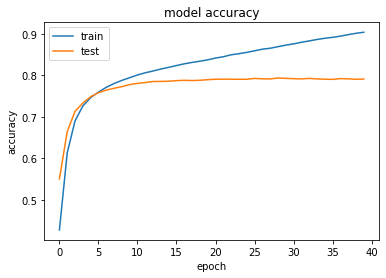

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss evolution by epochs

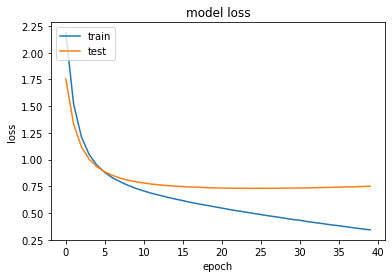

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating

In [16]:
score = model.evaluate(sp.lil_matrix(x_test).toarray(), y_test,
                       batch_size=batch_size, verbose=1)

print('Categorical crossentropy:', score[0])
print('Categorical accuracy:', score[1])

72399/72399 [==============================] - 4s 60us/sample - loss: 0.7627 - acc: 0.7868
Categorical crossentropy: 0.7626880357854249
Categorical accuracy: 0.7868479


In [17]:
pred = model.predict(sp.lil_matrix(x_test).toarray())
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis = 1)

report = Report(
    array_result = np.array([
        y_true.tolist(),
        y_pred.tolist(),
        X_test.gender_name.to_list()
    ]), categories = categories
)

print(report)

                   precision    recall  f1-score   diff_di   support

           pastor      0.670     0.622     0.645     0.148      1354
            model      0.848     0.869     0.858     0.229      6297
               dj      0.734     0.702     0.718     0.104      1465
        physician      0.781     0.718     0.748     0.041      2175
         comedian      0.856     0.558     0.675     2.166       459
software_engineer      0.765     0.717     0.740     0.055      1034
            nurse      0.645     0.732     0.686     2.692      4144
             poet      0.797     0.765     0.781     0.188      1533
          dentist      0.673     0.535     0.596     0.912       269
     chiropractor      0.809     0.657     0.725     0.251       245
        filmmaker      0.773     0.661     0.713     0.287       319
        professor      0.864     0.667     0.752     0.049       285
     yoga_teacher      0.799     0.806     0.803     0.856      1135
     photographer      0.790     